# Lab 6: Transformers and LLMs
```
- [S25] Advanced Machine Learning, Innopolis University
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Transformers (translation architecture)
2. Self-Attention
3. Multi-headed attention
4. Positional Encoding
5. Transfomer Encoder Part
6. Application of Transformers
7. Self practice tasks
```

<hr>


# 1. Transformers

* [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) -- Original paper on attention

![](http://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png)

## 1.1 Transfomer Encoder

The encoder contains a self-attention layer – a layer that helps the encoder look at other words in the input sentence as it encodes a specific word. <br>
PyTorch implementation : `nn.TransformerEncoder` and `nn.TransformerEncoderLayer` <br>
**The main goal is to efficiently encode the data**

  1         |  2
:-------------------------:|:-------------------------:
![](http://jalammar.github.io/images/t/encoder_with_tensors.png)  |  ![](http://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png)


## 2. Self-Attention

**Keep in mind : The main goal is to encode the data in a much more efficient way** In other words is to create meaningful embeddings<br>
- As the model processes each word (each position in the input sequence), self attention allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word.


**How does Self-Attention work?**

Steps:
1. For each word, we create a **`Query`** vector, a **`Key`** vector, and a **`Value`** vector.
  - What are the **`Query`** vector, a **`Key`** vector, and a **`Value`** vector? : They're abstractions that are useful for calculating attention... They are a breakdown of the word embeddings
2. Calculating self-attention score from **`Query`** **`Key`** vector.
3. Divide the scores by 8 (This leads to having more stable gradients)
4. Pass the result through a softmax operation (softmax score determines how much each word will be expressed at this position)
5. Multiply each value vector by the softmax score
6. Sum up the weighted value vectors

### Step 1

For each word, we create a **`Query`** vector, a **`Key`** vector, and a **`Value`** vector.

![](http://jalammar.github.io/images/t/transformer_self_attention_vectors.png)

In [1]:
import torch

# simple sequence = I will pass AML midterm
simple_sequence_embedding = torch.rand((5, 512))

# Create weight matrices
Wq = torch.normal(0,0.5, (512, 7))
Wk = torch.normal(0,0.1, (512, 7))
Wv = torch.normal(0,0.2, (512, 7))


# Create key, query and value for each word in the senetence
queries = simple_sequence_embedding @ Wq # (5, 512) @ (512, 7) = (5, 7)
keys = simple_sequence_embedding @ Wk # (5, 512) @ (512, 7) = (5, 7)
values = simple_sequence_embedding @ Wv# (5, 512) @ (512, 7) = (5, 7)

### Step 2

Calculating self-attention score from **`Query`** and **`Key`** vector

In [2]:
scores = torch.matmul(queries, keys.T) # (5, 7) @ (5, 7).T = (5, 5)
scores

tensor([[75.9083, 49.0921, 86.7839, 43.8658, 71.3354],
        [57.8434, 45.6210, 80.5351, 33.2011, 59.9751],
        [78.9122, 53.2926, 89.6036, 42.8810, 68.6121],
        [57.9094, 43.7398, 77.3212, 39.5014, 69.6231],
        [55.2869, 45.3307, 71.5603, 30.3435, 63.9426]])

### Step 3
Divide the scores by 8 (This leads to having more stable gradients)

In [3]:
# Divide the result to stabilize the gradients
scores = scores / 8 # Divide the result by 8 to stabilize the gradients
scores

tensor([[ 9.4885,  6.1365, 10.8480,  5.4832,  8.9169],
        [ 7.2304,  5.7026, 10.0669,  4.1501,  7.4969],
        [ 9.8640,  6.6616, 11.2005,  5.3601,  8.5765],
        [ 7.2387,  5.4675,  9.6652,  4.9377,  8.7029],
        [ 6.9109,  5.6663,  8.9450,  3.7929,  7.9928]])

### Step 4

Pass the result through a softmax operation

In [4]:
scores =  torch.softmax(scores, dim=1)
scores

tensor([[0.1814, 0.0064, 0.7065, 0.0033, 0.1024],
        [0.0510, 0.0111, 0.8691, 0.0023, 0.0665],
        [0.1948, 0.0079, 0.7413, 0.0022, 0.0538],
        [0.0591, 0.0101, 0.6692, 0.0059, 0.2557],
        [0.0838, 0.0241, 0.6410, 0.0037, 0.2473]])

### Step 5 & 6

* Multiply each value vector by the softmax score
* Sum up the weighted value vectors



In [5]:
# Multiply each value vector by the corresponding softmax score
z = torch.matmul(scores, values)  # (5, 5) @ (5, 7) -> (5, 7)

## 3. Multi-headed attention

**GOAL**:
1. Expand the model's ability to focus on different positions
2. Provide the attention layer multiple “representation subspaces”

**Attention with $N$ just means repeating self attention algorithm $N$ times and joining the results**


![](https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png)

**Multi-headed attention steps:**
1. Same as self-attention calculation, just n different times with different weight matrices
2. Condense the $N$ z metrices down into a single matrix by concatinating the matrices then multiply them by an additional weights matrix `WO`

Now the output z metrix is fed to the FFNN

In [6]:
from torch import Tensor
import torch.nn.functional as f
from torch import nn


def scaled_dot_product_attention(query, key, value):
  temp = query.bmm(key.transpose(1, 2))
  scale = query.size(-1) ** 0.5
  softmax = f.softmax(temp / scale, dim=-1)
  return softmax.bmm(value)

### 3.1 Attention head

In [7]:
class AttentionHead(nn.Module):
    def __init__(self, dim_in, dim_q, dim_k):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_q)  # Linear transformation for Query
        self.k = nn.Linear(dim_in, dim_k)  # Linear transformation Key
        self.v = nn.Linear(dim_in, dim_k)  # Linear transformation Value

    def forward(self, query, key, value):
        q = self.q(query)  
        k = self.k(key)    
        v = self.v(value)  

        return scaled_dot_product_attention(q, k, v)

### 3.2 Multi Head Attention

**Task:** Implement multi-head attention model

In [8]:
class MultiHeadAttention(nn.Module):
  def __init__(self, number_of_heads, dim_in, dim_q, dim_k):
    super().__init__()
    self.heads = nn.ModuleList([AttentionHead(dim_in, dim_q, dim_k) for _ in range(number_of_heads)])
    self.linear = nn.Linear(number_of_heads* dim_k, dim_in)

  def forward(self, query, key, value):
    z = self.linear(torch.cat([h(query, key, value) for h in self.heads], dim=-1))
    return z


## 4. Positional Encoding

A way to account for the order of the words in the input sequence. A transformer adds a vector to each input embedding which helps it determine the position of each word. <br>
**Goal** : preserving information about the order of tokens  

Positional Encoding they can either be learned or fixed a priori.

Proposed approach from original paper : describe a simple scheme for fixed positional encodings based on sine and cosine functions

In [9]:
def position_encoding(seq_len, dim_model, device):
  pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
  dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
  phase = pos / (1e4 ** (dim / dim_model))

  return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

![](http://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png)

## 5. Transfomer Encoder Part
### 5.1Encoder Feed Forward

In [10]:
def feed_forward(dim_input = 512, dim_feedforward = 2048):
  return nn.Sequential(nn.Linear(dim_input, dim_feedforward), nn.ReLU(), nn.Linear(dim_feedforward, dim_input))

### 5.2 Encoder Residual

From the original paper the author implementation

In [11]:
class Residual(nn.Module):
  def __init__(self, sublayer, dimension, dropout = 0.1):
    super().__init__()
    self.sublayer = sublayer
    self.norm = nn.LayerNorm(dimension)
    self.dropout = nn.Dropout(dropout)

  def forward(self, *tensors):
    return self.norm(tensors[0] + self.dropout(self.sublayer(*tensors)))

### 5.3 Putting the Encoder layer together

In [12]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, dim_model = 512, num_heads = 6, dim_feedforward = 2048, dropout = 0.1):
    super().__init__()
    dim_q = dim_k = max(dim_model // num_heads, 1)
    self.attention = Residual(MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
                              dimension=dim_model, dropout=dropout)
    self.feed_forward = Residual(feed_forward(dim_model, dim_feedforward), dimension=dim_model, dropout=dropout)

  def forward(self, src):
    src = self.attention(src, src, src)
    return self.feed_forward(src)

## 5.4 Putting together transfomer Encoder part

In [13]:
class TransformerEncoder(nn.Module):
  def __init__(self, num_layers = 12, dim_model = 512, num_heads = 4, dim_feedforward = 2048, dropout: float = 0.1):
    super().__init__()
    self.layers = nn.ModuleList([TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout) for _ in range(num_layers) ])

  def forward(self, src):
    seq_len, dimension = src.size(1), src.size(2)
    src += position_encoding(seq_len, dimension)
    for layer in self.layers:
      src = layer(src)

    return src

# The Decoder Side

The encoder start by processing the input sequence. The output of the top encoder is then transformed into a set of attention vectors K and V. These are to be used by each decoder.

The “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the `Keys` and `Values` matrix from the output of the encoder stack.

![](https://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png)


## Decoder layer



**Task**: implement the decoder layer

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, dim_model=512, num_heads=8, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)

        # Masked Multi-Head Attention (for Decoder)
        self.masked_attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model, dropout=dropout
        )

        # Encoder-Decoder Attention
        self.encoder_decoder_attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model, dropout=dropout
        )

        # Feed Forward Network
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model, dropout=dropout
        )

    def forward(self, tgt, memory):
        # Masked attention for the decoder
        tgt = self.masked_attention(tgt, tgt, tgt)
        
        # Encoder-Decoder Attention: tgt - это Queries, memory - это Keys и Values
        tgt = self.encoder_decoder_attention(tgt, memory, memory)
        
        return self.feed_forward(tgt)


## 6. Application of Transfomers

We will look at sentiment analysis

In [15]:
%pip install transformers


Note: you may need to restart the kernel to use updated packages.


In [16]:
import transformers

class Transformer(nn.Module):

  def __init__(self, output_dim):
    super().__init__()
    self.transformer = transformers.AutoModel.from_pretrained('bert-base-uncased')
    for param in self.transformer.parameters():
        param.requires_grad = False

    hidden_dim = self.transformer.config.hidden_size
    self.fc = nn.Linear(hidden_dim, output_dim)


  def forward(self, text):
    # text = [batch size, seq len]
    output = self.transformer(text, output_attentions=True)
    hidden = output.last_hidden_state
    # hidden = [batch size, seq len, hidden dim]
    attention = output.attentions[-1]
    # attention = [batch size, n heads, seq len, seq len]
    cls_hidden = hidden[:, 0, :]
    prediction = self.fc(torch.tanh(cls_hidden))

    return prediction

## 7. Tasks

```
Task 1
- Using the above implementation code the decoder layer and assemble a full transformer model
```

<hr>

```
Task 2
- Implement, train and test a Transfomer model (use pytorch layers)for Part-of-speech tagging task.
```

**Task 2 Datasets**: [Train](https://www.dropbox.com/s/x9n6f9o9jl7pno8/train_pos.txt?dl=1), [Test](https://www.dropbox.com/s/v8nccvq7jewcl8s/test_pos.txt?dl=1)


In [17]:
class DecoderLayer(nn.Module):
    def __init__(self, dim_model=512, num_heads=8, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)

        # Masked Multi-Head Attention (для автокоррекции в декодере)
        self.masked_attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model, dropout=dropout
        )
        self.norm1 = nn.LayerNorm(dim_model)  # Нормализация

        # Encoder-Decoder Attention
        self.encoder_decoder_attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model, dropout=dropout
        )
        self.norm2 = nn.LayerNorm(dim_model)

        # Feed Forward Network
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model, dropout=dropout
        )
        self.norm3 = nn.LayerNorm(dim_model)

    def forward(self, tgt, memory, tgt_mask=None):
        # Masked attention для декодера (применяем маску)
        tgt = self.norm1(tgt + self.masked_attention(tgt, tgt, tgt, mask=tgt_mask))

        # Encoder-Decoder Attention
        tgt = self.norm2(tgt + self.encoder_decoder_attention(tgt, memory, memory))

        # Feed Forward Network
        return self.norm3(tgt + self.feed_forward(tgt))


In [18]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads=8, num_layers=6, dim_model=512, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.encoder = TransformerEncoder(num_layers, dim_model, num_heads, dim_feedforward, dropout)
        
        # Используем несколько слоёв декодера
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(dim_model, num_heads, dim_feedforward, dropout) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(dim_model, output_dim)

    def forward(self, src, tgt, tgt_mask=None):
        # Кодировщик
        memory = self.encoder(src)

        # Последовательное пропускание через декодер
        for layer in self.decoder_layers:
            tgt = layer(tgt, memory, tgt_mask)

        return self.fc_out(tgt)


## Task 2 

In [29]:
from collections import defaultdict

def load_data(filename):
    sentences, tags = [], []
    with open(filename, "r", encoding="utf-8") as f:
        sentence, tag_seq = [], []
        for line in f:
            line = line.strip()
            if line:
                word, tag = line.split()
                sentence.append(word)
                tag_seq.append(tag)
            else:
                sentences.append(sentence)
                tags.append(tag_seq)
                sentence, tag_seq = [], []
    return sentences, tags

train_sentences, train_tags = load_data("train_pos.txt")
test_sentences, test_tags = load_data("test_pos.txt")

print("Example data:")
print(train_sentences[0])
print(train_tags[0])

Example data:
['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits', '.']
['NN', 'IN', 'DT', 'NN', 'VBZ', 'RB', 'VBN', 'TO', 'VB', 'DT', 'JJ', 'NN', 'IN', 'NN', 'NNS', 'IN', 'NNP', ',', 'JJ', 'IN', 'NN', 'NN', ',', 'VB', 'TO', 'VB', 'DT', 'JJ', 'NN', 'IN', 'NNP', 'CC', 'NNP', 'POS', 'JJ', 'NNS', '.']


In [20]:
# Creating dictionaries of tokens and tags
word_to_idx = defaultdict(lambda: len(word_to_idx))
tag_to_idx = defaultdict(lambda: len(tag_to_idx))

# Adding special tokens
word_to_idx["<PAD>"], word_to_idx["<UNK>"] = 0, 1
tag_to_idx["<PAD>"] = 0

# Filling in dictionaries
for sentence, tags in zip(train_sentences, train_tags):
    for word, tag in zip(sentence, tags):
        word_to_idx[word]
        tag_to_idx[tag]

# Reverse dictionaries for decoding
idx_to_word = {v: k for k, v in word_to_idx.items()}
idx_to_tag = {v: k for k, v in tag_to_idx.items()}

print("Word Dictionary Size:", len(word_to_idx))
print("Size of the tag dictionary:", len(tag_to_idx))


Размер словаря слов: 19124
Размер словаря тегов: 45


In [21]:
from torch.utils.data import Dataset, DataLoader
class POSTaggingDataset(Dataset):
    def __init__(self, sentences, tags, word_to_idx, tag_to_idx, max_len=100):
        self.sentences = [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sent] for sent in sentences]
        self.tags = [[tag_to_idx[tag] for tag in tag_seq] for tag_seq in tags]
        self.max_len = max_len  # Maximum sentence length
        self.pad_idx = word_to_idx["<PAD>"]
        self.tag_pad_idx = tag_to_idx["<PAD>"]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sent, tag_seq = self.sentences[idx], self.tags[idx]

        # Padding до max_len
        pad_length = self.max_len - len(sent)
        if pad_length > 0:
            sent += [self.pad_idx] * pad_length
            tag_seq += [self.tag_pad_idx] * pad_length
        else:
            sent = sent[:self.max_len]
            tag_seq = tag_seq[:self.max_len]

        return torch.tensor(sent), torch.tensor(tag_seq)

In [22]:
def get_dataloader(sentences, tags, word_to_idx, tag_to_idx, batch_size=32, max_len=100):
    dataset = POSTaggingDataset(sentences, tags, word_to_idx, tag_to_idx, max_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Creating DataLoaders
train_loader = get_dataloader(train_sentences, train_tags, word_to_idx, tag_to_idx, batch_size=32)
test_loader = get_dataloader(test_sentences, test_tags, word_to_idx, tag_to_idx, batch_size=32)


In [23]:
# Let's check what the batch files look like
for batch in train_loader:
    sample_sentences, sample_tags = batch
    print("Example of a batch of sentences (words):", sample_sentences.shape)
    print("Example of a tag batch:", sample_tags.shape)
    break

Пример батча предложений (слов): torch.Size([32, 100])
Пример батча тегов: torch.Size([32, 100])


In [24]:
class TransformerPOSTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embed_dim=128, hidden_dim=256, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)  # Embedding layer
        self.pos_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, tagset_size)  # Output layer for tag prediction

    def forward(self, x):
        x = self.embedding(x)  # Converting word indexes to vectors
        x = self.pos_encoder(x)  # Processing via Transformer
        x = self.fc(x)  # Running it through the Linear layer
        return x  # Returning logits (without softmax)


In [25]:
import torch.optim as optim

EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating a model
model = TransformerPOSTagger(vocab_size=len(word_to_idx), tagset_size=len(tag_to_idx)).to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tag_to_idx["<PAD>"])  # Ignore paddings
optimizer = optim.AdamW(model.parameters(), lr=LR)

# Training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        sentences, tags = batch
        sentences, tags = sentences.to(device), tags.to(device)

        optimizer.zero_grad()
        outputs = model(sentences)  # [batch_size, seq_len, num_tags]

        loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))  # CrossEntropy requires [batch*num_words, num_tags]
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [26]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            sentences, tags = batch
            sentences, tags = sentences.to(device), tags.to(device)

            outputs = model(sentences)  # [batch_size, seq_len, num_tags]
            loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))

            total_loss += loss.item()

            # Подсчёт accuracy
            predictions = outputs.argmax(dim=-1)  # We take the indexes with the maximum value (predicted tags)
            mask = tags != tag_to_idx["<PAD>"]  # Removing paddings
            correct += (predictions[mask] == tags[mask]).sum().item()
            total += mask.sum().item()

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

Epoch 1/10 - Train Loss: 2.3247 | Val Loss: 1.6798 | Val Acc: 0.5193
Epoch 2/10 - Train Loss: 1.4555 | Val Loss: 1.3352 | Val Acc: 0.6026
Epoch 3/10 - Train Loss: 1.2067 | Val Loss: 1.1718 | Val Acc: 0.6555
Epoch 4/10 - Train Loss: 1.0624 | Val Loss: 1.0216 | Val Acc: 0.6926
Epoch 5/10 - Train Loss: 0.9528 | Val Loss: 0.9263 | Val Acc: 0.7247
Epoch 6/10 - Train Loss: 0.8623 | Val Loss: 0.8384 | Val Acc: 0.7563
Epoch 7/10 - Train Loss: 0.7869 | Val Loss: 0.7645 | Val Acc: 0.7799
Epoch 8/10 - Train Loss: 0.7241 | Val Loss: 0.7128 | Val Acc: 0.7932
Epoch 9/10 - Train Loss: 0.6725 | Val Loss: 0.6684 | Val Acc: 0.8070
Epoch 10/10 - Train Loss: 0.6290 | Val Loss: 0.6338 | Val Acc: 0.8168


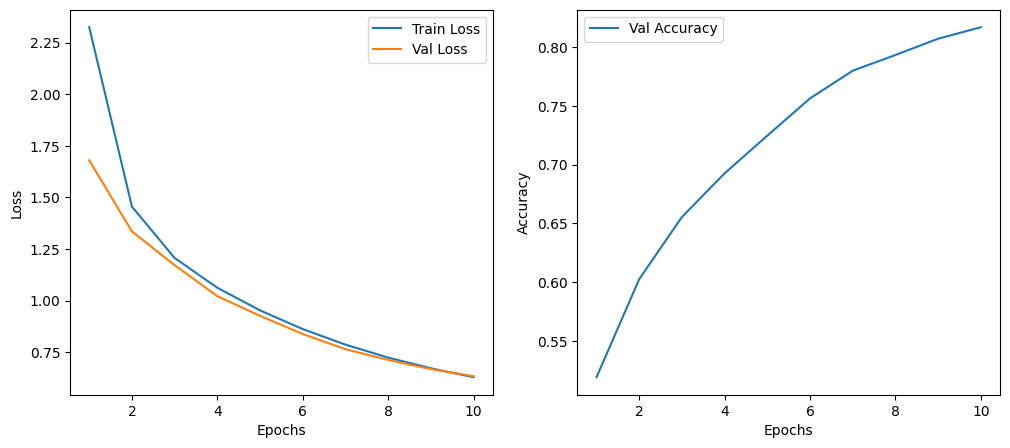

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Graphs for visualizing loss and accuracy
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = evaluate(model, test_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), val_accuracies, label="Val Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [28]:
def predict(model, sentence, word_to_idx, idx_to_tag, device):
    model.eval()
    tokens = [word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence]
    input_tensor = torch.tensor(tokens).unsqueeze(0).to(device)  # Adding batch dim
    with torch.no_grad():
        output = model(input_tensor)
        predictions = output.argmax(dim=-1).squeeze(0)  # Taking the most likely tags
    return [idx_to_tag[idx.item()] for idx in predictions]

# Checking predictions
test_sentence = ["Rockwell", "said", "the", 'agreement', 'calls']
predicted_tags = predict(model, test_sentence, word_to_idx, idx_to_tag, DEVICE)

print("Sentence:", test_sentence)
print("Predicted Tags:", predicted_tags)


Sentence: ['Rockwell', 'said', 'the', 'agreement', 'calls']
Predicted Tags: ['NNP', 'VBD', 'DT', 'NN', 'NNP']
